In [25]:
import numpy as np
import pandas as pd
import edhec_risk_kit as erk

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Present Value of Liabilities and Funding Ratio

부채를 현재 가치로 환산

부채 -> 같은 원리로 채권의 현재 가치를 계산

ex) 은퇴시 필요한 자금은 얼마일까?, 만기 시점에 부채를 모두 갚기 위해서 필요한 현재 자금은 얼마인가?

In [26]:
def discount(t, r):
    return (1+r)**(-t)

In [27]:
# 10년 후 $1의 현재 가치는? (금리 3%인 경우)
1 * discount(10, 0.03)

0.7440939148967249

In [28]:
def pv(l, r):
    """
    l: 날짜 -- 부채
    """
    dates = l.index  ## 해당 날짜
    discounts = discount(dates, r)  ## 해당 날짜를 기준으로 PV 단위
    return (discounts*l).sum()

In [29]:
liabilities = pd.Series(index=[3, 3.5, 4, 4.5], data=[1, 1.5, 2, 2.5])
liabilities

3.0    1.0
3.5    1.5
4.0    2.0
4.5    2.5
dtype: float64

In [30]:
pv(liabilities, 0.03)

6.233320315080045

In [31]:
# 총합이 7인 부채가 현재 가치로는 6.233..
liabilities.sum()

7.0

In [32]:
# 부채 대비 자산 비율
def funding_ratio(assets, liailities, r):
    return assets/pv(liabilities, r)

In [33]:
# 지금 자산이 5인데, 위 경우처럼 7만큼 부채가 있고 금리가 3%인 경우에 Funding ratio
funding_ratio(5, liabilities, 0.03)

0.8021407126958777

In [34]:
# 금리가 내려가면 부채 가치가 증가해서 Funding ratio는 더 나빠짐!!
# why? - 금리가 내려가면 지금 내 자산가치가 내려가고, 부채는 상대적으로 가치가 높아짐
funding_ratio(5, liabilities, 0.02)

0.7720304366941648

In [35]:
import ipywidgets as widgets
from IPython.display import display

In [36]:
def show_funding_ratio(assets, r):
    fr = funding_ratio(assets, liabilities, r)
    print('{0:.2f}'.format(fr*100))
    
controls = widgets.interactive(show_funding_ratio,
                              assets = widgets.IntSlider(min=1, max=10, step=1, value=5),
                               r = (0, .20, .01)
                              )
display(controls)

interactive(children=(IntSlider(value=5, description='assets', max=10, min=1), FloatSlider(value=0.1, descript…

In [37]:
# 부채를 갚으려면 지금 자산을 늘리거나 수익률을 높이거나
liabilities

3.0    1.0
3.5    1.5
4.0    2.0
4.5    2.5
dtype: float64

# CIR(Cox-Ingersoll-Ross) Model to simulate changes in Interest Rates and Liability Hedging

$$ dr_t = a(b-r_t)dt + \sigma \sqrt{r_t}dW_t $$



Liability Hedging Portfolios(LHP)

Goal Hedging Portfolios(GHP)


Funding ratio에서 금리에 따라 분모(부채가치)가 변하는만큼 분자(자산가치)도 동일 비율만큼 변하도록 설계

## Short Rate vs Annualized

$$ 1+r_{annual} = e^{r_{short}} $$

In [38]:
def inst_to_ann(r):
    """
    Short rate -> Annualized rate
    """
    return np.expm1(r)

def ann_to_inst(r):
    """
    Annualized rate -> Short rate
    """
    return np.log1p(r)

$$ dr_t = a(b-r_t)dt + \sigma \sqrt{r_t}dW_t $$

In [39]:
# CIR model 만들기

def cir(n_years=10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    if r_0 is None: r_0 = b ## r초기값이 없으면 b랑 동일
    r_0 = ann_to_inst(r_0)
    dt = 1/steps_per_year
    
    num_steps = int(n_years*steps_per_year)  ## 정수처리
    shock = np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios)) ## 평균 0, 표준편차 루트dt
    rates = np.empty_like(shock)
    rates[0] = r_0
    for step in range(1, num_steps):
        r_t = rates[step-1]
        d_r_t = a*(b-r_t)*dt + sigma*np.sqrt(r_t)*shock[step]
        rates[step] = abs(r_t + d_r_t)
        
    return pd.DataFrame(data=inst_to_ann(rates), index=range(num_steps))

<AxesSubplot:>

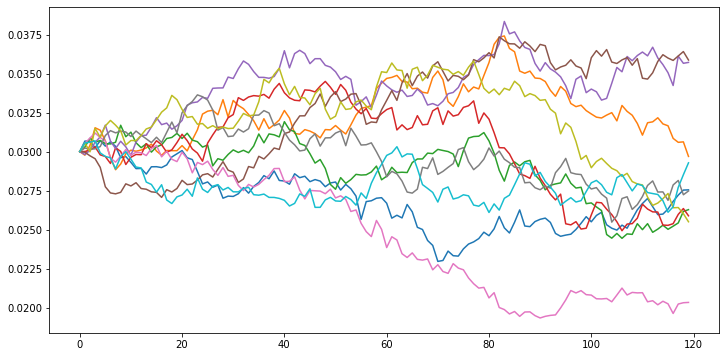

In [40]:
cir(n_scenarios=10, sigma=0.01).plot(legend=False, figsize=(12,6))

In [41]:
def show_cir(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=5):
    cir(r_0=r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios).plot(legend=False, figsize=(12,6))
    
controls = widgets.interactive(show_cir,
                              r_0 = (0, .15, .01),
                               a = (0, 1, 0.1),
                               b = (0, .15, .01),
                               sigma = (0, .1, .01),
                               n_scenarios = (1, 100)
                              )
display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

CIR모델로 zero coupon bond 가격 구하기

참고 : https://wikidocs.net/92488

t시간일 때 bond의 가격 P

$$ P(t,T) = A(t,T)e^{-B(t,T)r_{t}} $$

$$ A(t,T) = \left({\frac {2h e^{(a+h)\tau/2}}{2h+(a+h)(e^{\tau h}-1)}}\right)^{{2ab/\sigma^{2}}} $$

$$ B(t,T) = {\frac {2(e^{\tau h}-1)}{2h+(a+h)(e^{\tau h}-1)}} $$

$$ h = {\sqrt{a^2+2 \sigma^{2}}} $$

$$ \tau = T-t $$

In [42]:
import math
def cir(n_years=10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    """
    Implements the CIR model for interest rates
    """
    if r_0 is None: r_0 = b
    r_0 = ann_to_inst(r_0)
    dt = 1/steps_per_year
    
    num_steps = int(n_years*steps_per_year) + 1
    shock = np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0
    
    ## For Price Generation
    h = math.sqrt(a**2 + 2*sigma**2)
    prices = np.empty_like(shock)
    
    def price(ttm, r):
        _A = ((2*h*math.exp((h+a)*ttm/2))/(2*h+(h+a)*(math.exp(h*ttm)-1)))**(2*a*b/sigma**2)
        _B = (2*(math.exp(h*ttm)-1))/(2*h+(h+a)*(math.exp(h*ttm)-1))
        _P = _A*np.exp(-_B*r)
        return _P
    prices[0] = price(n_years, r_0)
    
    for step in range(1, num_steps):
        r_t = rates[step-1]
        d_r_t = a*(b-r_t)*dt + sigma*np.sqrt(r_t)*shock[step]
        rates[step] = abs(r_t + d_r_t)
        prices[step] = price(n_years-step*dt, rates[step])
        
    rates = pd.DataFrame(data=inst_to_ann(rates), index=range(num_steps))
    prices = pd.DataFrame(data=prices, index=range(num_steps))
    
    return rates, prices

In [43]:
def show_cir_prices(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=5):
    cir(r_0=r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios)[1].plot(legend=False, figsize=(12,6))

controls = widgets.interactive(show_cir_prices,
                              n_scenarios=widgets.IntSlider(min=1, max=100, step=1, value=30),
                               a=(0, 1, 0.1),
                               b=(0, 0.5, 0.01),
                               sigma=(0, 0.5, 0.01),
                               r_0=(0, 0.15, 0.01)
                              )

display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

r이 낮아지면 채권가격은 상승

r이 높아지면 채권가격은 하락

In [44]:
a_0 = .75
rates, bond_prices = cir(n_years=10, r_0=0.03, b=0.03, n_scenarios=10)
liabilities = bond_prices
zcbond_10 = pd.Series(data=[1], index=[10])  ## 10년짜리 채권
zc_0 = erk.pv(zcbond_10, r=0.03)  ## 제로쿠폰채권 현재 가격
n_bonds = a_0/zc_0
av_zc_bonds = n_bonds*bond_prices ## 자산에서 채권 비중
av_cash = a_0*(rates/12+1).cumprod()  ## 현금만 들고 있는 경우에 자산


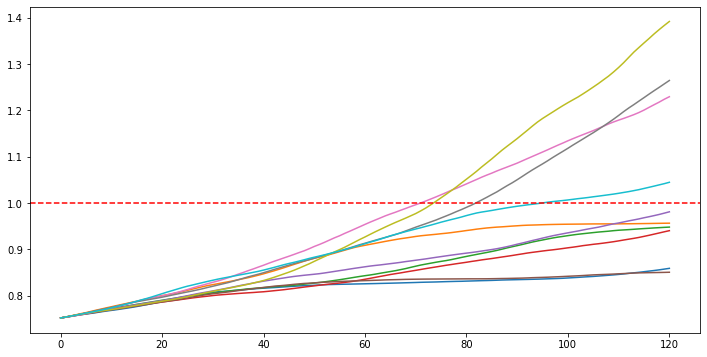

In [45]:
ax = av_cash.plot(legend=False, figsize=(12,6))  ## 현금만 들고 있는 경우 자산 추이(r=3%)
ax.axhline(y=1, color='r', linestyle='--')

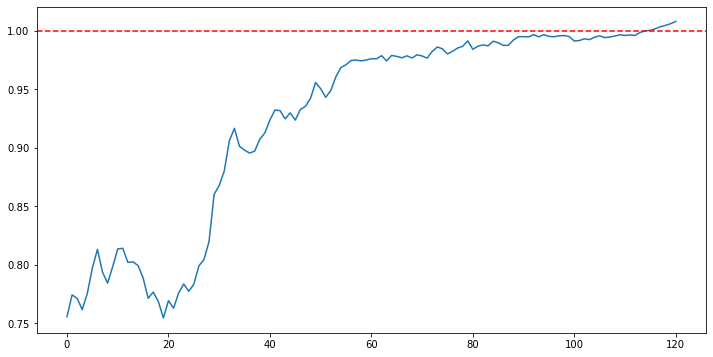

In [46]:
ax = av_zc_bonds.plot(legend=False, figsize=(12,6))  ## 채권 들고 있는 경우 자산 추이(r=3%)
ax.axhline(y=1, color='r', linestyle='--')

<AxesSubplot:>

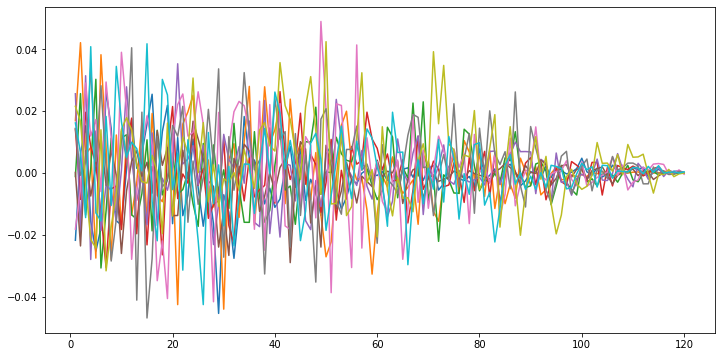

In [47]:
(av_cash/liabilities).pct_change().plot(legend=False, figsize=(12,6))
## Funding ratio 관점에서 봤을 때, 현금의 변동성

<AxesSubplot:>

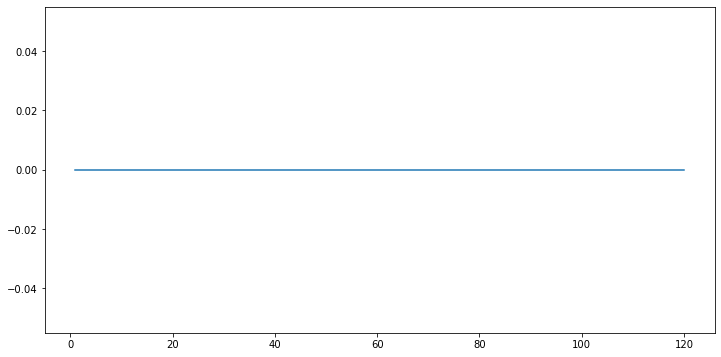

In [48]:
(av_zc_bonds/liabilities).pct_change().plot(legend=False, figsize=(12,6))
## Funding ratio 관점에서 봤을 때, 채권의 변동성

현금이 더 안정적이고 변동성이 없어보이지만, Funding ratio 관점에서는 변동성이 높음

채권은 변동성이 커 보이지만, 만기일에 확실하게 cash를 확보할 수 있음

In [49]:
a_0 = .75
rates, bond_prices = cir(n_years=10, r_0=0.03, b=0.03, n_scenarios=10000)
liabilities = bond_prices
zcbond_10 = pd.Series(data=[1], index=[10])
zc_0 = erk.pv(zcbond_10, r=0.03)
n_bonds = a_0/zc_0
av_zc_bonds = n_bonds*bond_prices
av_cash = a_0*(rates/12+1).cumprod()

<AxesSubplot:label='4891cda6-b433-494e-9d25-6387f9f44869'>

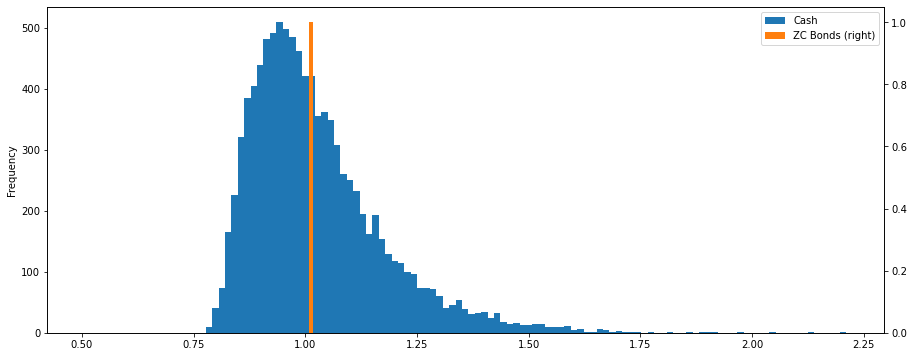

In [50]:
tfr_cash = av_cash.iloc[-1]/liabilities.iloc[-1]
tfr_zc_bonds = av_zc_bonds.iloc[-1]/liabilities.iloc[-1]
ax = tfr_cash.plot.hist(label='Cash', figsize=(15,6), bins=100, legend=True)
tfr_zc_bonds.plot.hist(ax=ax, label='ZC Bonds', bins=100, legend=True, secondary_y=True)

# GHP Construction with Duration Matching

In [54]:
def bond_cash_flows(maturity, principal=100, coupon_rate=0.03, coupons_per_year=12):
    """
    Returns a series of cash flows generated by a bond,
    indexed by a coupon number
    """
    n_coupons = round(maturity*coupons_per_year)  ## N년짜리 채권 * 일년에 나오는 쿠폰 수
    coupon_amt = principal*coupon_rate/coupons_per_year  ## 쿠폰 하나 가치
    coupon_times = np.arange(1, n_coupons+1)  ## 쿠폰 나오는 횟수
    cash_flows = pd.Series(data=coupon_amt, index=coupon_times) ## 쿠폰 데이터
    cash_flows.iloc[-1] += principal  ## 만기일에는 원금 돌려줌
    return cash_flows

In [55]:
def bond_price(maturity, principal=100, coupon_rate=0.03, coupons_per_year=12, discount_rate=0.03):
    """
    Price a bond based on bond paramters maturity, principal, coupon rate and coupons_per_year
    and the prevailing discount rate
    """
    cash_flows = bond_cash_flows(maturity, principal, coupon_rate, coupons_per_year)
    return pv(cash_flows, discount_rate/coupons_per_year)  ## 위에서 만든 채권 데이터를 pv로 환산

In [56]:
erk.bond_cash_flows(3, 100, 0.03, 2)

1      1.5
2      1.5
3      1.5
4      1.5
5      1.5
6    101.5
dtype: float64

In [57]:
# 현재 금리가 3%일 때, 5%짜리 채권의 현재 가치
bond_price(20, 1000, 0.05, 2, 0.03)

1299.1584520417491

In [58]:
rates = np.linspace(.01, .1, 20)
rates

array([0.01      , 0.01473684, 0.01947368, 0.02421053, 0.02894737,
       0.03368421, 0.03842105, 0.04315789, 0.04789474, 0.05263158,
       0.05736842, 0.06210526, 0.06684211, 0.07157895, 0.07631579,
       0.08105263, 0.08578947, 0.09052632, 0.09526316, 0.1       ])

In [59]:
prices = [erk.bond_price(10, 1000, .05, 2, rate) for rate in rates]
prices

[0    1379.748383
 dtype: float64,
 0    1326.762928
 dtype: float64,
 0    1276.163298
 dtype: float64,
 0    1227.833538
 dtype: float64,
 0    1181.663651
 dtype: float64,
 0    1137.549279
 dtype: float64,
 0    1095.3914
 dtype: float64,
 0    1055.096038
 dtype: float64,
 0    1016.573997
 dtype: float64,
 0    979.740605
 dtype: float64,
 0    944.515473
 dtype: float64,
 0    910.822268
 dtype: float64,
 0    878.588497
 dtype: float64,
 0    847.745306
 dtype: float64,
 0    818.227287
 dtype: float64,
 0    789.972298
 dtype: float64,
 0    762.92129
 dtype: float64,
 0    737.018147
 dtype: float64,
 0    712.209532
 dtype: float64,
 0    688.444741
 dtype: float64]

<AxesSubplot:>

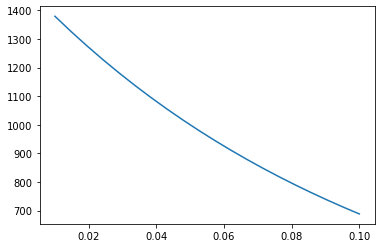

In [60]:
# 금리에 따른 액면가 1000, 5%짜리 채권 가치
# 시중 금리에 따라 가격변동성이 큼!
pd.DataFrame(data=prices, index=rates).plot(legend=False)

In [61]:
cf = erk.bond_cash_flows(3, 1000, .06, 2)
cf

1      30.0
2      30.0
3      30.0
4      30.0
5      30.0
6    1030.0
dtype: float64

In [62]:
# cashflow를 현재가치로 환산
# 각 시점의 price에 discount value를 곱한 값
discounts = erk.discount(cf.index, .06/2)
discounts

,0
1,0.970874
2,0.942596
3,0.915142
4,0.888487
5,0.862609
6,0.837484


In [63]:
dcf = discounts * cf
dcf

,0,1,2,3,4,5,6
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
# 각 시점에 discount weights
weights = dcf/dcf.sum()
weights

,0,1,2,3,4,5,6
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Macaulay duration

weighted average duration.

discount weights value에 기간을 곱해서 구한 duration

만약 내가 가진 자산의 duration이 길다면 금리 영향을 더 많이 받는다! -> 금리의 영향 정도를 나타내주는 항목

In [65]:
cf.index*weights

ValueError: Unable to coerce to Series, length must be 7: given 6

In [66]:
np.average(cf.index, weights=weights)

TypeError: Axis must be specified when shapes of a and weights differ.

In [67]:
(cf.index*weights).sum()

ValueError: Unable to coerce to Series, length must be 7: given 6

In [68]:
def macaulay_duration(flows, discount_rate):
    """
    Computes the Macaulay Duration of a sequence of cash flows
    """
    discounted_flows = discount(flows.index, discount_rate)*flows  ## cashflow pv값
    weights = discounted_flows/discounted_flows.sum()
    return np.average(flows.index, weights=weights)  ## index(기간)*weights

In [69]:
erk.macaulay_duration(erk.bond_cash_flows(3, 1000, .06, 2), .06/2)

TypeError: Axis must be specified when shapes of a and weights differ.

Funding ratio에서 분자(자산)와 분모(부채)의 Macaulay duration값을 일치하도록 자산을 배분하면 금리가 변해도 Funding ratio는 변하지 않음

Duration Matching

In [49]:
# 10년, 12년짜리 부채
liabilities = pd.Series(data=[100000, 100000], index=[10, 12])
erk.macaulay_duration(liabilities, .04)

10.960799385088393

In [71]:
# 10년, 20년짜리 채권의 MD
md_10 = erk.macaulay_duration(erk.bond_cash_flows(10, 1000, .05, 1), .04)
md_20 = erk.macaulay_duration(erk.bond_cash_flows(20, 1000, .05, 1), .04)

TypeError: Axis must be specified when shapes of a and weights differ.

In [72]:
md_10, md_20

NameError: name 'md_10' is not defined

$$ w_s \times 8.19 + (1-w_s) \times 13.54 = 10.96 $$

In [73]:
# liabiliries와 같은 duration을 만들 때 단기채의 비율
short_bond = erk.bond_cash_flows(10, 1000, .05, 1)
long_bond = erk.bond_cash_flows(20, 1000, .05, 1)
w_s = erk.match_durations(liabilities, short_bond, long_bond, .04)
w_s

TypeError: Axis must be specified when shapes of a and weights differ.

In [74]:
short_bond

1       50.0
2       50.0
3       50.0
4       50.0
5       50.0
6       50.0
7       50.0
8       50.0
9       50.0
10    1050.0
dtype: float64

In [54]:
p_short = erk.bond_price(10, 1000, .05, 1, .04)
p_long = erk.bond_price(20, 1000, .05, 1, .04)
a_0 = 130000

In [70]:
# 처음 자산(a_0)에서 단기채와 장기채가 차지하는 비율과 그 후 현금흐름(p_flows)
p_flows = pd.concat([a_0*w_s*short_bond/p_short, a_0*(1-w_s)*long_bond/p_long])
erk.macaulay_duration(p_flows, .04)

NameError: name 'w_s' is not defined

In [56]:
cfr = erk.funding_ratio(p_flows, liabilities, .04)
cfr

0.9998760012192478

In [57]:
rates = np.linspace(0, .1, 20)
lb_assets = a_0 * long_bond / p_long
sb_assets = a_0 * short_bond / p_short

fr_change = pd.DataFrame({
    "Long Bond": [erk.funding_ratio(lb_assets, liabilities, r) for r in rates],
    "Short Bond": [erk.funding_ratio(sb_assets, liabilities, r) for r in rates],
    "Duration Matched Bonds": [erk.funding_ratio(p_flows, liabilities, r) for r in rates]
}, index=rates)

fr_change

,Long Bond,Short Bond,Duration Matched Bonds
0.000000,1.144464,0.901852,1.027372
0.005263,1.119809,0.913844,1.020404
0.010526,1.096992,0.926095,1.014512
0.015789,1.075935,0.938613,1.009659
0.021053,1.056570,0.951405,1.005814
0.026316,1.038829,0.964481,1.002946
0.031579,1.022651,0.977851,1.001029
0.036842,1.007979,0.991523,1.000037
0.042105,0.994759,1.005508,0.999947
0.047368,0.982943,1.019815,1.000739


<AxesSubplot:>

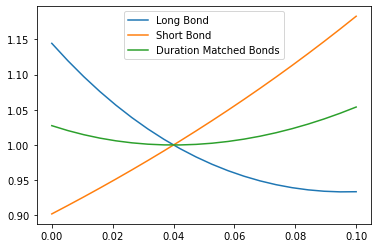

In [58]:
# 금리가 오르면 단기채 가격은 상승 장기채는 하락, DMB는 비교적 안정
fr_change.plot()